<a href="https://colab.research.google.com/github/Riky2014/Tesi/blob/main/1d_hemo_solver_branch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt-get install software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install fenics

In [107]:
from fenics import *

import logging
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the logging level to suppress FFC messages
logging.getLogger('UFL_LEGACY').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.ERROR)

# Data, Mesh and Function spaces

In [156]:
# Data
x_inlet = 0.
x_branch = 1.0
x_outlet_1 = 2.0
x_outlet_2 = 3.0
T = 1

alpha = 1
k_r = 2.416e-4
rho = 1.05

K_1 = 50e3
K_2 = 50e3
K_3 = 50e3

# Discretization parameter
dt = 1e-4
num_steps = T / dt

h_1 = 1 / 32
h_2 = 1 / 32
h_3 = 1 / 32
N_1 = int((x_branch - x_inlet) / h_1)
N_2 = int((x_outlet_1 - x_branch) / h_2)
N_3 = int((x_outlet_2 - x_branch) / h_3)

#  Create a mesh on the interval [0, 1], [1, 2] and [1, 3].
mesh_1 = IntervalMesh(N_1, x_inlet, x_branch)
mesh_2 = IntervalMesh(N_2, x_branch, x_outlet_1)
mesh_3 = IntervalMesh(N_3, x_branch, x_outlet_2)

# Define the function space
P1_1 = FiniteElement('P', mesh_1.ufl_cell(), 1)
P1_2 = FiniteElement('P', mesh_2.ufl_cell(), 1)
P1_3 = FiniteElement('P', mesh_3.ufl_cell(), 1)
element_1 = MixedElement([P1_1, P1_1])
element_2 = MixedElement([P1_2, P1_2])
element_3 = MixedElement([P1_3, P1_3])
V_1 = FunctionSpace(mesh_1, element_1)
V_2 = FunctionSpace(mesh_2, element_2)
V_3 = FunctionSpace(mesh_3, element_3)

# Derivative function space
D1_1 = FiniteElement('DG', mesh_1.ufl_cell(), 0)
D1_2 = FiniteElement('DG', mesh_2.ufl_cell(), 0)
D1_3 = FiniteElement('DG', mesh_3.ufl_cell(), 0)
element_der_1 = MixedElement([D1_1, D1_1])
element_der_2 = MixedElement([D1_2, D1_2])
element_der_3 = MixedElement([D1_3, D1_3])
V_der_1 = FunctionSpace(mesh_1, element_der_1)
V_der_2 = FunctionSpace(mesh_2, element_der_2)
V_der_3 = FunctionSpace(mesh_3, element_der_3)

# Functions

In [157]:
def H(A, q, A0, K):
  return as_tensor([[0, 1], [K / (2 * rho * A0 ** 0.5) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def F(A, q, A0, K):
  return as_vector([q, K / (3 * rho * A0 ** 0.5) * A ** 1.5 - K / (3 * rho) * A0 + q ** 2 / A])

def B(A, q):
  return as_vector([0, k_r * q / A])

def S(A, q):
  return as_vector([0, k_r * q / A])

def dS_dU(A, q):
  return as_tensor([[0, 0], [- k_r * q / A ** 2, k_r / A]])

In [158]:
def U(A, q):
  return np.array([A, q])

def H_vec(A, q, A0, K):
  return np.array([[0, 1], [K / (2 * rho * A0 ** 0.5) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def B_vec(A, q):
  return np.array([0, k_r * q / A])

def S_vec(A, q):
  return np.array([0, k_r * q / A])

def c_alpha(A, q, A0, K, alpha = 1):
  return (K / (2 * rho * A0 ** 0.5) * A ** 0.5 + (q / A) ** 2 * alpha * (alpha - 1)) ** 0.5

def l1(A, q, A0, K, alpha = 1):
  return np.array([c_alpha(A, q, A0, K, alpha) - alpha * q / A, 1.])

def l2(A, q, A0, K, alpha = 1):
  return np.array([- c_alpha(A, q, A0, K, alpha) - alpha * q / A, 1.])

def CC(A, q, A0, K, u_der, V_der, x):
  du_dz = project(u_der, V_der)(x)
  return U(A, q) - dt * H_vec(A, q, A0, K) @ du_dz - dt * B_vec(A, q)

In [159]:
def inlet_bc(A, q, A0, K, u_der, V_der, x):
  q_inlet = (np.dot(l2(A(x), q(x), A0, K), CC(A(x), q(x), A0, K, u_der, V_der, x)) - l2(A(x), q(x), A0, K)[0] * U(A(x), q(x))[0] ) / l2(A(x), q(x), A0, K)[1]

  return q_inlet

def outlet_bc(A, q, A0, K, u_der, V_der, x):
  matrix = np.array([[1, -1], [c_alpha(A(x), q(x), A0, K, alpha) + alpha * q(x) / A(x), c_alpha(A(x), q(x), A0, K, alpha) - alpha * q(x) / A(x)]])
  array = np.array([np.dot(l1(A(x), q(x), A0, K), CC(A(x), q(x), A0, K, u_der, V_der, x)), np.dot(l2(A(x), q(x), A0, K), U(A(x), q(x)) - dt * S_vec(A(x), q(x)))])

  A_out, q_out = matrix @ array / (2 * c_alpha(A(x), q(x), A0, K, alpha))

  return A_out, q_out

In [160]:
def plot_solution():
  fig, ax = plt.subplots(2, 2, figsize=(12, 12))
  ax = ax.flatten()

  # Format t to print only the first 4 digits
  formatted_t = "{:.5f}".format(t)

  # Plot for Area
  ax[0].plot(Ah.compute_vertex_values(mesh), label='Approximation')
  ax[0].plot(A_ex.compute_vertex_values(mesh), label='Exact')
  ax[0].set_title(f'Area, t = {formatted_t}')
  ax[0].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')
  ax[0].legend()

  ax[2].plot(np.abs(Ah.compute_vertex_values(mesh) - A_ex.compute_vertex_values(mesh)))
  ax[2].set_title(f'Error')
  ax[2].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')

  # Plot for Flux
  ax[1].plot(qh.compute_vertex_values(mesh) - np.mean(qh.compute_vertex_values(mesh)), label='Approximation')
  ax[1].plot(q_ex.compute_vertex_values(mesh), label='Exact')
  ax[1].set_title(f'Flux, t = {formatted_t}')
  ax[1].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')
  ax[1].legend()

  ax[3].plot(np.abs(qh.compute_vertex_values(mesh) - q_ex.compute_vertex_values(mesh) - np.mean(qh.compute_vertex_values(mesh))))
  ax[3].set_title(f'Error')
  ax[3].set_xlabel(f'N = {N}, h = {h},  dt = {dt}')

  plt.show()

# Definition of the variational problem

In [161]:
# Define the variational problem
def LinearProblem(A, q, v, z, A_old, q_old, A0, K):
  a = inner(A, v) * dx + inner(q, z) * dx

  l = (
        A_old * v * dx
      + q_old * z * dx
      + dt * ((F(A_old, q_old, A0, K) - dt / 2 * dot(H(A_old, q_old, A0, K), S(A_old, q_old))))[0] * v.dx(0) * dx
      + dt * ((F(A_old, q_old, A0, K) - dt / 2 * dot(H(A_old, q_old, A0, K), S(A_old, q_old))))[1] * z.dx(0) * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old, A0, K).dx(0)))[0] * v * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old, A0, K).dx(0)))[1] * z * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old, A0, K), F(A_old, q_old, A0, K).dx(0)))[0] * v.dx(0) * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old, A0, K), F(A_old, q_old, A0, K).dx(0)))[1] * z.dx(0) * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[0] * v * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[1] * z * dx
  )

  return a, l

# Single branch problem

In [162]:
def local_branch_solution(bc, V, A_old, q_old, A0, K):
  # Define trial functions and test functions
  A, q = TrialFunctions(V)
  v, z = TestFunctions(V)
  uh = Function(V)

  a, l = LinearProblem(A, q, v, z, A_old, q_old, A0, K)
  solve(a == l, uh, bc)

  return uh

# Branching

In [163]:
def C_A_in(A, q, A0, beta, gamma):
  return beta / (2 * rho * A0 * sqrt(A)) - (q ** 2 / A ** 3) * (1 - 2 * gamma * np.sign(q))

def C_q_in(A, q, A0, gamma):
  return (q / A ** 2) * (1 - 2 * gamma * np.sign(q))

def b_in(A, q, A0, beta, gamma):
  return beta / rho * (A - 2 * sqrt(A * A0)) / (2 * A0 * sqrt(A)) + 0.5 * (q / A) ** 2 * (1 - 2 * gamma * np.sign(q))

def C_A_out(A, q, A0, alpha, beta, gamma):
  return beta / (2 * rho * A0 * sqrt(A)) - (q ** 2 / A ** 3) * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

def C_q_out(A, q, A0, alpha, gamma):
  return (q / A ** 2) * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

def b_out(A, q, A0, alpha, beta, gamma):
  return beta / rho * (A - 2 * sqrt(A * A0)) / (2 * A0 * sqrt(A)) + 0.5 * (q / A) ** 2 * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

In [182]:
def compute_branch_value(Ah_1, Ah_2, Ah_3, qh_1, qh_2, qh_3, uh_old_1, uh_old_2, uh_old_3, x_branch, toll):

  A_branch_old_1 = Ah_1(x_branch)
  A_branch_old_2 = Ah_2(x_branch)
  A_branch_old_3 = Ah_3(x_branch)

  q_branch_old_1 = qh_1(x_branch)
  q_branch_old_2 = qh_2(x_branch)
  q_branch_old_3 = qh_3(x_branch)

  A_branch_0_1 = A_branch_old_1
  A_branch_0_2 = A_branch_old_2
  A_branch_0_3 = A_branch_old_3

  q_branch_0_1 = q_branch_old_1
  q_branch_0_2 = q_branch_old_2
  q_branch_0_3 = q_branch_old_3

  err = float('inf')
  iter = 0

  while (err > toll) & (iter < 100):

    iter += 1

    lhs = np.zeros((6, 6))
    rhs = np.zeros(6)

    lhs[0, 3] =  1
    lhs[0, 4] = -1
    lhs[0, 5] = -1

    lhs[1, 0] =   C_A_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    lhs[1, 1] = - C_A_out(A_branch_old_2, q_branch_old_2, A0_2, alpha_2, beta_2, gamma_2)
    lhs[1, 3] =   C_q_in(A_branch_old_1, q_branch_old_1, A0_1, gamma_1)
    lhs[1, 4] = - C_q_out(A_branch_old_2, q_branch_old_2, A0_2, alpha_2, gamma_2)

    lhs[2, 0] =   C_A_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    lhs[2, 2] = - C_A_out(A_branch_old_3, q_branch_old_3, A0_3, alpha_3, beta_3, gamma_3)
    lhs[2, 3] =   C_q_in(A_branch_old_1, q_branch_old_1, A0_1, gamma_1)
    lhs[2, 5] = - C_q_out(A_branch_old_3, q_branch_old_3, A0_3, alpha_3, gamma_3)

    lhs[3, 0] = l1(A_branch_old_1, q_branch_old_1, A0_1, K_1)[0]
    lhs[3, 3] = l1(A_branch_old_1, q_branch_old_1, A0_1, K_1)[1]

    lhs[4, 1] = l2(A_branch_old_2, q_branch_old_2, A0_2, K_2)[0]
    lhs[4, 4] = l2(A_branch_old_2, q_branch_old_2, A0_2, K_2)[1]

    lhs[5, 2] = l2(A_branch_old_3, q_branch_old_3, A0_3, K_3)[0]
    lhs[5, 5] = l2(A_branch_old_3, q_branch_old_3, A0_3, K_3)[1]

    rhs[1] = b_out(A_branch_old_2, q_branch_old_2, A0_2, alpha_2, beta_2, gamma_2) - b_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    rhs[2] = b_out(A_branch_old_3, q_branch_old_3, A0_3, alpha_3, beta_3, gamma_3) - b_in(A_branch_old_1, q_branch_old_1, A0_1, beta_1, gamma_1)
    rhs[3] = np.dot(l1(A_branch_old_1, q_branch_old_1, A0_1, K_1), CC(A_branch_old_1, q_branch_old_1, A0_1, K_1, uh_old_1.dx(0), V_der_1, x_branch))
    rhs[4] = np.dot(l2(A_branch_old_2, q_branch_old_2, A0_2, K_2), CC(A_branch_old_2, q_branch_old_2, A0_2, K_2, uh_old_2.dx(0), V_der_2, x_branch))
    rhs[5] = np.dot(l2(A_branch_old_3, q_branch_old_3, A0_3, K_3), CC(A_branch_old_3, q_branch_old_3, A0_3, K_3, uh_old_3.dx(0), V_der_3, x_branch))

    A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3 = np.linalg.solve(lhs, rhs)

    if (q_branch_0_1 == 0) or (q_branch_0_2 == 0) or (q_branch_0_3 == 0):
      err = abs(A_branch_1 - A_branch_old_1) / A_branch_0_1 + abs(A_branch_2 - A_branch_old_2) / A_branch_0_2 + abs(A_branch_3 - A_branch_old_3) / A_branch_0_3 \
          + abs(q_branch_1 - q_branch_old_1) + abs(q_branch_2 - q_branch_old_2) + abs(q_branch_3 - q_branch_old_3)
    else:
      err = abs(A_branch_1 - A_branch_old_1) / A_branch_0_1 + abs(A_branch_2 - A_branch_old_2) / A_branch_0_2 + abs(A_branch_3 - A_branch_old_3) / A_branch_0_3 \
          + abs(q_branch_1 - q_branch_old_1) / q_branch_0_1 + abs(q_branch_2 - q_branch_old_2) / q_branch_0_2 + abs(q_branch_3 - q_branch_old_3) / q_branch_0_3

    A_branch_old_1 = A_branch_1
    A_branch_old_2 = A_branch_2
    A_branch_old_3 = A_branch_3

    q_branch_old_1 = q_branch_1
    q_branch_old_2 = q_branch_2
    q_branch_old_3 = q_branch_3

  return A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter

# Initial guess

In [188]:
# Define initial guess
A0_1 = 4e-4
A0_2 = 4e-4
A0_3 = 5e-4

q0_1 = 0
q0_2 = 0
q0_3 = 0

uh_old_1 = interpolate(Expression(('A0', 'q0'), degree = 1, A0 = A0_1, q0 = q0_1), V_1)
uh_old_2 = interpolate(Expression(('A0', 'q0'), degree = 1, A0 = A0_2, q0 = q0_2), V_2)
uh_old_3 = interpolate(Expression(('A0', 'q0'), degree = 1, A0 = A0_3, q0 = q0_3), V_3)

Ah_old_1, qh_old_1 = uh_old_1.split()
Ah_old_2, qh_old_2 = uh_old_2.split()
Ah_old_3, qh_old_3 = uh_old_3.split()

# Boundary conditon

In [189]:
beta_1 = K_1 / sqrt(A0_1)
beta_2 = K_2 / sqrt(A0_2)
beta_3 = K_3 / sqrt(A0_3)

gamma_1 = 0
gamma_2 = 2
gamma_3 = 2

alpha_2 = pi / 4
alpha_3 = pi / 3

In [190]:
# Boundary condition
inlet = 'near(x[0], 0)'
branch = 'near(x[0], 1)'
outlet_1 = 'near(x[0], 2)'
outlet_2 = 'near(x[0], 3)'

A_inlet = Ah_old_1(x_inlet)
q_inlet = inlet_bc(Ah_old_1, qh_old_1, A0_1, K_1, uh_old_1.dx(0), V_der_1, x_inlet)

A_outlet_1, q_outlet_1 = outlet_bc(Ah_old_2, qh_old_2, A0_2, K_2, uh_old_2.dx(0), V_der_2, x_outlet_1)
A_outlet_2, q_outlet_2 = outlet_bc(Ah_old_3, qh_old_3, A0_3, K_3, uh_old_3.dx(0), V_der_3, x_outlet_2)

A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter = compute_branch_value(Ah_old_1, Ah_old_2, Ah_old_3, qh_old_1, qh_old_2, qh_old_3, uh_old_1, uh_old_2, uh_old_3,x_branch, 1e-4)

print(f'A inlet = {A_inlet}, q inlet = {q_inlet}, A_1 branch = {A_branch_1}, q_1 branch = {q_branch_1}')
print(f'A_2 branch = {A_branch_2}, q_2 branch = {q_branch_2}, A outlet_1 = {A_outlet_1}, q outlet_1 = {q_outlet_1}')
print(f'A_3 branch = {A_branch_3}, q_3 branch = {q_branch_3}, A outlet_2 = {A_outlet_2}, q outlet_2 = {q_outlet_2}')

A inlet = 0.0004, q inlet = 0.0, A_1 branch = 0.0004000000000000001, q_1 branch = 0.0
A_2 branch = 0.0004000000000000001, q_2 branch = 0.0, A outlet_1 = 0.0004, q outlet_1 = -4.603574158483219e-19
A_3 branch = 0.0005, q_3 branch = -0.0, A outlet_2 = 0.0005, q outlet_2 = 4.979847537585411e-19


In [191]:
def update_bc(A_inlet, q_inlet, A_outlet_1, q_outlet_1, A_outlet_2, q_outlet_2, A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3):

  bc_A_inlet = DirichletBC(V_1.sub(0), A_inlet, inlet)
  bc_q_inlet = DirichletBC(V_1.sub(1), q_inlet, inlet)
  bc_A_branch_1 = DirichletBC(V_1.sub(0), A_branch_1, branch)
  bc_q_branch_1 = DirichletBC(V_1.sub(1), q_branch_1, branch)

  bc_A_branch_2 = DirichletBC(V_2.sub(0), A_branch_2, branch)
  bc_q_branch_2 = DirichletBC(V_2.sub(1), q_branch_2, branch)
  bc_A_outlet_1 = DirichletBC(V_2.sub(0), A_outlet_1, outlet_1)
  bc_q_outlet_1 = DirichletBC(V_2.sub(1), q_outlet_1, outlet_1)

  bc_A_branch_3 = DirichletBC(V_3.sub(0), A_branch_3, branch)
  bc_q_branch_3 = DirichletBC(V_3.sub(1), q_branch_3, branch)
  bc_A_outlet_2 = DirichletBC(V_3.sub(0), A_outlet_2, outlet_2)
  bc_q_outlet_2 = DirichletBC(V_3.sub(1), q_outlet_2, outlet_2)

  bc_1 = [bc_A_inlet, bc_q_inlet, bc_A_branch_1, bc_q_branch_1]
  bc_2 = [bc_A_outlet_1, bc_q_outlet_1, bc_A_branch_2, bc_q_branch_2]
  bc_3 = [bc_A_outlet_2, bc_q_outlet_2, bc_A_branch_3, bc_q_branch_3]

  return bc_1, bc_2, bc_3

bc_1, bc_2, bc_3 = update_bc(A_inlet, q_inlet, A_outlet_1, q_outlet_1, A_outlet_2, q_outlet_2, A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3)

# Solution

In [192]:
# Time stepping
t = 0

for n in tqdm(range(round(num_steps))):

  # Update time step
  t += dt

  # Solve the problem
  uh_1 = local_branch_solution(bc_1, V_1, Ah_old_1, qh_old_1, A0_1, K_1)
  uh_2 = local_branch_solution(bc_2, V_2, Ah_old_2, qh_old_2, A0_2, K_2)
  uh_3 = local_branch_solution(bc_3, V_3, Ah_old_3, qh_old_3, A0_3, K_3)

  Ah_1, qh_1 = uh_1.split(deepcopy = True)
  Ah_2, qh_2 = uh_2.split(deepcopy = True)
  Ah_3, qh_3 = uh_3.split(deepcopy = True)

  # Update previous solution
  Ah_old_1.assign(Ah_1)
  qh_old_1.assign(qh_1)
  Ah_old_2.assign(Ah_2)
  qh_old_2.assign(qh_2)
  Ah_old_3.assign(Ah_3)
  qh_old_3.assign(qh_3)

  # Update bc
  A_inlet = A0_1 + 0.0001 * t
  q_inlet = inlet_bc(Ah_1, qh_1, A0_1, K_1, uh_1.dx(0), V_der_1, x_inlet)

  A_outlet_1, q_outlet_1 = outlet_bc(Ah_2, qh_2, A0_2, K_2, uh_2.dx(0), V_der_2, x_outlet_1)
  A_outlet_2, q_outlet_2 = outlet_bc(Ah_3, qh_3, A0_3, K_3, uh_3.dx(0), V_der_3, x_outlet_2)

  A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter = compute_branch_value(Ah_1, Ah_2, Ah_3, qh_1, qh_2, qh_3, uh_1, uh_2, uh_3, x_branch, 1e-3)

  bc_1, bc_2, bc_3 = update_bc(A_inlet, q_inlet, A_outlet_1, q_outlet_1, A_outlet_2, q_outlet_2, A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3)

  if(n % 5 == 0):
    print()
    print(f'At step {n} took {iter} iteration to impose the branching condition')

  0%|          | 2/10000 [00:00<25:02,  6.66it/s]


At step 0 took 1 iteration to impose the branching condition


  0%|          | 6/10000 [00:01<34:32,  4.82it/s]


At step 5 took 23 iteration to impose the branching condition


  0%|          | 12/10000 [00:03<39:58,  4.16it/s]


At step 10 took 1 iteration to impose the branching condition


  0%|          | 18/10000 [00:04<29:53,  5.57it/s]


At step 15 took 1 iteration to impose the branching condition


  0%|          | 22/10000 [00:05<33:29,  4.96it/s]


At step 20 took 1 iteration to impose the branching condition


  0%|          | 28/10000 [00:07<44:51,  3.71it/s]


At step 25 took 100 iteration to impose the branching condition


  0%|          | 32/10000 [00:07<28:07,  5.91it/s]


At step 30 took 1 iteration to impose the branching condition


  0%|          | 37/10000 [00:09<42:06,  3.94it/s]


At step 35 took 1 iteration to impose the branching condition


  0%|          | 43/10000 [00:10<34:42,  4.78it/s]


At step 40 took 100 iteration to impose the branching condition


  0%|          | 45/10000 [00:10<27:36,  6.01it/s]


At step 45 took 100 iteration to impose the branching condition


  1%|          | 52/10000 [00:13<31:14,  5.31it/s]


At step 50 took 1 iteration to impose the branching condition


  1%|          | 58/10000 [00:15<43:41,  3.79it/s]  


At step 55 took 1 iteration to impose the branching condition


  1%|          | 64/10000 [00:16<20:51,  7.94it/s]


At step 60 took 1 iteration to impose the branching condition


  1%|          | 68/10000 [00:18<55:40,  2.97it/s]  


At step 65 took 100 iteration to impose the branching condition


  1%|          | 70/10000 [00:18<41:52,  3.95it/s]


At step 70 took 1 iteration to impose the branching condition


  1%|          | 76/10000 [00:20<49:27,  3.34it/s]


At step 75 took 100 iteration to impose the branching condition


  1%|          | 81/10000 [00:21<35:12,  4.70it/s]


At step 80 took 1 iteration to impose the branching condition


  1%|          | 84/10000 [00:23<46:19,  3.57it/s]  


TypeError: float() argument must be a string or a real number, not 'complex'

NameError: name 'A_branch_old_1' is not defined

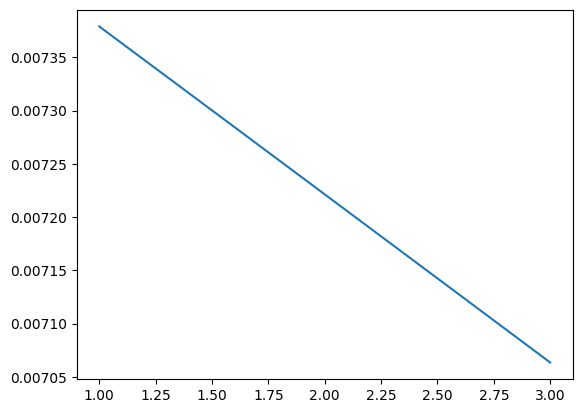

In [144]:
plot(qh_3)

# Space convergence

In [ ]:
h_vec = [1 / (2 ** i) for i in range(5, 9)]
dt = 1e-5
num_steps = T / dt

error_A = []
error_q = []

for h in h_vec:
  print(f'h = {h}, dt = {dt}')
  print()

  N = int((x_outlet - x_inlet) / h)

  mesh = IntervalMesh(N, x_inlet, x_outlet)
  x = MeshCoordinates(mesh)

  V = FunctionSpace(mesh, element)
  V_der = FunctionSpace(mesh, element_der)
  V_ex = FunctionSpace(mesh, element_exact)

  f_n = project(f, V)
  df_dt_n = project(df_dt, V)

  uh_old = interpolate(Expression(('A_tilde + a_tilde * sin(2 * pi / L * x[0])', 'q0'), degree = 2, A_tilde = A_tilde, a_tilde = a_tilde, L = L, q0 = q0), V)
  Ah_old, qh_old = uh_old.split()

  bc_A_inlet = DirichletBC(V.sub(0), A_inlet, inlet)
  bc_q_inlet = DirichletBC(V.sub(1), q_inlet, inlet)
  bc_A_outlet = DirichletBC(V.sub(0), A_outlet, outlet)
  bc_q_outlet = DirichletBC(V.sub(1), q_outlet, outlet)

  bc = [bc_A_inlet, bc_q_inlet, bc_A_outlet, bc_q_outlet]

  A, q = TrialFunctions(V)
  v, z = TestFunctions(V)

  uh = Function(V)
  t = 0
  i = 0

  global_error_A = 0
  global_error_q = 0

  for n in range(round(num_steps)):

    i +=1

    # Update time step
    t = update_time_step(t, dt)
    f_n = project(f, V)
    df_dt_n = project(df_dt, V)

    # Solve the problem
    a, L = LinearProblem(Ah_old, qh_old)
    solve(a == L, uh, bc)
    Ah, qh = uh.split(deepcopy = True)

    A_e = interpolate(A_exact, V_ex.sub(0).collapse())
    q_ex = interpolate(q_exact, V_ex.sub(1).collapse())
    q_zero_mean.assign(qh)
    q_zero_mean.vector()[:] -= assemble(qh*dx)/assemble(1*dx(domain=mesh))
    error = np.array([errornorm(Ah, A_ex, 'L2'), errornorm(q_zero_mean, q_ex, 'L2')])

    if error[0] > global_error_A:
      global_error_A = error[0]

    if error[1] > global_error_q:
      global_error_q = error[1]

    # Compute errors
    if (i % 1000 == 0):
      print(f'Interation {i} / {round(num_steps)}')
      print(f't = %.4f: error = {error}' % (t))
      print(f'Global error A = {global_error_A}, Global error q = {global_error_q}')
      print()

    if (i % 10000 == 0):
      plot_solution()

    # Update previous solution
    Ah_old.assign(Ah)
    qh_old.assign(qh)

    q_inlet = inlet_bc(Ah_old, qh_old, uh.dx(0))
    A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh.dx(0))
    bc = update_bc(A_inlet, q_inlet, A_outlet, q_outlet)

  print(f'N = {N}, h = {h}, dt = {dt} : Global error A = {global_error_A}, Global error q = {global_error_q}')
  error_A.append(global_error_A)
  error_q.append(global_error_q)

In [ ]:
h_vec = np.array([1/32, 1 /64, 1/128, 1/256])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

# Plot for Area
ax[0].plot(error_A)
ax[0].set_title('Area')
ax[0].set_xlabel(f'h = {h_vec},  dt = {dt}')
ax[0].set_ylabel('Error')

ax[2].loglog(h_vec / h_vec[0], error_A / error_A[0], label = 'L^2 Error')
ax[2].loglog(h_vec / h_vec[0], h_vec / h_vec[0], linestyle = '--', label = 'h')
ax[2].loglog(h_vec / h_vec[0], (h_vec / h_vec[0])**2, linestyle = '--', label ='h^2')
ax[2].set_xlabel('h')
ax[2].set_ylabel('Error')
ax[2].set_title('Area')
ax[2].legend()

# Plot for Flux
ax[1].plot(error_q)
ax[1].set_title('Flux')
ax[1].set_xlabel(f'h = {h_vec},  dt = {dt}')
ax[1].set_ylabel('Error')

ax[3].loglog(h_vec / h_vec[0], error_q / error_q[0], label = 'L^2 Error')
ax[3].loglog(h_vec / h_vec[0], h_vec / h_vec[0], linestyle = '--', label = 'h')
ax[3].loglog(h_vec / h_vec[0], (h_vec / h_vec[0])**2, linestyle = '--', label = 'h^2')
ax[3].set_xlabel('h')
ax[3].set_ylabel('Error')
ax[3].set_title('Flux')
ax[3].legend()

# Time convergence

In [ ]:
# Time stepping
h = 1 / 32
dt_vec = 1e-4 * np.array([1, 1/2, 1/4, 1/8])
error_A = []
error_q = []

for dt in dt_vec:
  print(f'dt = {dt}')
  print()

  uh = Function(V)
  t = 0
  i = 0

  global_error_A = 0
  global_error_q = 0

  num_steps = T / dt

  for n in range(round(num_steps)):

    i +=1

    # Update time step
    t = update_time_step(t, dt)
    f_n = project(f, V)
    df_dt_n = project(df_dt, V)

    # Solve the problem
    a, L = LinearProblem(Ah_old, qh_old)
    solve(a == L, uh, bc)
    Ah, qh = uh.split(deepcopy = True)

    A_ex = interpolate(A_exact, V_ex.sub(0).collapse())
    q_ex = interpolate(q_exact, V_ex.sub(1).collapse())
    q_zero_mean.assign(qh)
    q_zero_mean.vector()[:] -= assemble(qh*dx)/assemble(1*dx(domain=mesh))
    error = np.array([errornorm(Ah, A_ex, 'L2'), errornorm(q_zero_mean, q_ex, 'L2')])

    if error[0] > global_error_A:
      global_error_A = error[0]

    if error[1] > global_error_q:
      global_error_q = error[1]

    # Compute errors
    if (i % 1000 == 0):
      print(f'Interation {i} / {round(num_steps)}')
      print(f't = %.4f: error = {error}' % (t))
      print(f'Global error A = {global_error_A}, Global error q = {global_error_q}')
      print()

    if (i % 10000 == 0):
      plot_solution()

    # Update previous solution
    Ah_old.assign(Ah)
    qh_old.assign(qh)

    q_inlet = inlet_bc(Ah_old, qh_old, uh.dx(0))
    A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh.dx(0))
    bc = update_bc(A_inlet, q_inlet, A_outlet, q_outlet)

  error_A.append(global_error_A)
  error_q.append(global_error_q)

In [ ]:
dt_vec = 1e-4 * np.array([1, 1/2, 1/4, 1/8])
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

# Plot for Area
ax[0].plot(error_A)
ax[0].set_title('Area')
ax[0].set_xlabel(f'h = {h},  dt = {dt_vec}')
ax[0].set_ylabel('Error')

ax[2].loglog(dt_vec / dt_vec[0], error_A / error_A[0], label = 'L^2 Error')
ax[2].loglog(dt_vec / dt_vec[0], dt_vec / dt_vec[0], linestyle = '--', label = 'dt')
ax[2].loglog(dt_vec / dt_vec[0], (dt_vec / dt_vec[0])**2, linestyle = '--', label ='dt^2')
ax[2].set_xlabel('dt')
ax[2].set_ylabel('Error')
ax[2].set_title('Area')
ax[2].legend()

# Plot for Flux
ax[1].plot(error_q)
ax[1].set_title('Flux')
ax[1].set_xlabel(f'h = {h},  dt = {dt_vec}')
ax[1].set_ylabel('Error')

ax[3].loglog(dt_vec / dt_vec[0], error_q / error_q[0], label = 'L^2 Error')
ax[3].loglog(dt_vec / dt_vec[0], dt_vec / dt_vec[0], linestyle = '--', label = 'dt')
ax[3].loglog(dt_vec / dt_vec[0], (dt_vec / dt_vec[0])**2, linestyle = '--', label = 'dt^2')
ax[3].set_xlabel('dt')
ax[3].set_ylabel('Error')
ax[3].set_title('Flux')
ax[3].legend()